## **Machine Learning - WNBA Playoffs Prediction**
This notebook will focus on the undestanding of the data. We will be using SQLite to store the data due to its scalability & the fact that it's a relational schema.

https://docs.python.org/3/library/sqlite3.html

Import sqlite3 and connect to database file

### **Imports**

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import feature_selection as fs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import prep_utils as pu
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings("ignore")
PAST_YEARS = 2
TEST_YEAR = 10
KAGGLE_TEST_YEAR = 11

### **Database Connection Setup**
The initial intake of data was loaded into a SQLite3 database. Further, in order to improve the effectiveness of further data transformation procedures, a calculated choice was taken to convert the data into a Pandas dataframe. Furthermore, Year 11 competition data has been added to the database, augmenting it.


In [17]:
db = sqlite3.connect("db/ac.db")
db_cur = db.cursor()

[df_awards, df_coaches, df_players_teams, df_players, df_series_post, df_teams_post, df_teams] = pu.db_to_pandas(db)

### **Data Preparation**

#### **Preparing Teams Dataframe**

+ Removed features deemed not important such as: arena, lgID, divID.
+ Removed features that were irrelevant (always have the same value for all entries)
+ Replaced features of the format feature_made & feature_attempted by its success rate; (3points, fieldgoal, regular_winrate, playoff_winrate)
+ Replaced FirstRound, Semis & Final by the teams playoff rank

In [18]:
df_new_teams = pu.prepare_teams(df_teams,df_teams_post, PAST_YEARS)
df_new_teams = fs.fs_teams(df_new_teams)
df_new_teams = pu.playoff_rank(df_new_teams,df_teams, PAST_YEARS)
#df_team_results = df_new_teams[["year","tmID","confID","playoff","rank","team_playoffs_count","playoff_rank"]]
df_team_results = df_new_teams[["year","tmID","confID","playoff","rank","team_playoffs_count","playoff_rank","Winrate","PO_Winrate"]]

Dropping divID in Teams...
Dropping ldID in Teams...
Dropping seeded in Teams...
Dropping tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB in Teams...
Dropping homeW, homeL, awayW, awayL, confW, confL, attend, name, franchID & arena in Teams...
Converting Target PLAYOFF to binary onTeams...
Creating attribute winrate Teams...
Dropping won & lost in Teams...
Creating attribute PlayOffs winrate Teams...


#### **Preparing Coaches Dataframe**

+ Replaced Wins/Losses by winrate. For both regular season & playoff
+ Created Coach Award Amount Feature
+ Created Coach PlayOff Appearances Feature

In [19]:
df_new_coaches = pu.prepare_coaches(df_coaches, df_awards,PAST_YEARS)
df_new_coaches = pu.group_coaches(df_new_coaches)

df_new_coaches.drop("coachID", axis = 1, inplace = True)

df_final_coaches = df_new_coaches.copy()
df_final_coaches.columns = df_final_coaches.columns.str.lower()


Dropping Attribute lgID in Coaches...
Creating attribute coach previous regular season win ratio...
Creating attribute coach playoffs win ratio...
Creating attribute coach playoffs count...
Creating attribute coach awards count...
Dropping attribute post_wins..
Dropping attribute post_losses..
Dropping attribute won..
Dropping attribute lost..

Coaches Null Verification:
year                    0
tmID                    0
coachID                 0
coach_reg_wr            0
coach_po_wr             0
coach_playoffs_count    0
coach_awards            0
dtype: int64


#### **Preparing Players Dataframe**
+ Created Player Award Amount Feature
+ Replaced features of the format feature_made & feature_attempted by its success rate;
+ In order to reduce the dataset dimensionality, we also aggregated the metrics that were common to both Regular Season & Playoffs in a **weighted** manner.


In [20]:
df_new_players_teams = pu.prepare_player_teams(df_players_teams,df_awards,PAST_YEARS)

Dropping Attribute lgID in Players_Teams...
Created Attribute Player_Awards in Players_Teams...


#### **Created 2 Team Ratings:**
+  One rated the players performance from the previous seasons. The goal is to assess the roster's capacity for consistent performance across a range of seasons, player growth, and the team's general quality and stability.

+ A rating that evaluates whether the team has had a roster of talented players in previous years. The goal of this rating is to assess the team's historical trend of acquiring or keeping high-caliber players as well as to provide a quantitative measure of the team's general quality and stability.

In [21]:
# How the team performed in the previous years
previous_team_ratings, df_new_players_team = pu.final_team_ratings(df_players_teams,df_awards, df_players, df_teams, PAST_YEARS)

# How the players performed in the previous years
previous_team_player_ratings = pu.final_player_team_ratings(df_teams, df_new_players_team, df_players, PAST_YEARS,df_new_players_teams[df_new_players_teams['year'] == KAGGLE_TEST_YEAR])

#### **Merging all dataframes into one final dataframe**

Although initially we are given a relational schema, in order for the machine learning models work with our data we will be merging the relevant data into a single dataframe. This consolidation not only streamlines the data for machine learning models but also facilitates a comprehensive analysis of the interplay between various features on a global scale. By merging the data based on the relational schema's key relationships, we ensure that the connections and dependencies within the dataset are accurately represented. This unified approach enables us to uncover patterns and correlations that might have been obscured when the data was compartmentalized in separate dataframes. In essence, our goal is to create a cohesive foundation that allows for a more nuanced understanding of how different features influence each other, offering insights that were previously elusive due to the fragmented nature of the dataset.

In [22]:
df_players = df_new_players_teams.copy()
df_players = fs.fs_players(df_players,0.2)
df_players = df_players[df_players['year'] != 1]


df_team_results.columns = df_team_results.columns.str.lower()
previous_team_player_ratings.columns = previous_team_player_ratings.columns.str.lower()


merged_data = pd.merge(df_players, df_team_results, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, df_final_coaches, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_ratings, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_player_ratings, on=['tmid', 'year'], how='left')


#### **Correlation Matrix**
We'll use a correlation matrix to gauge the relationships between continuous attributes. This tool provides a quantitative measure of correlation, helping us identify patterns and dependencies. By assessing correlation coefficients, we can understand how variables interact, crucial for refining our machine learning models and making informed decisions in development.

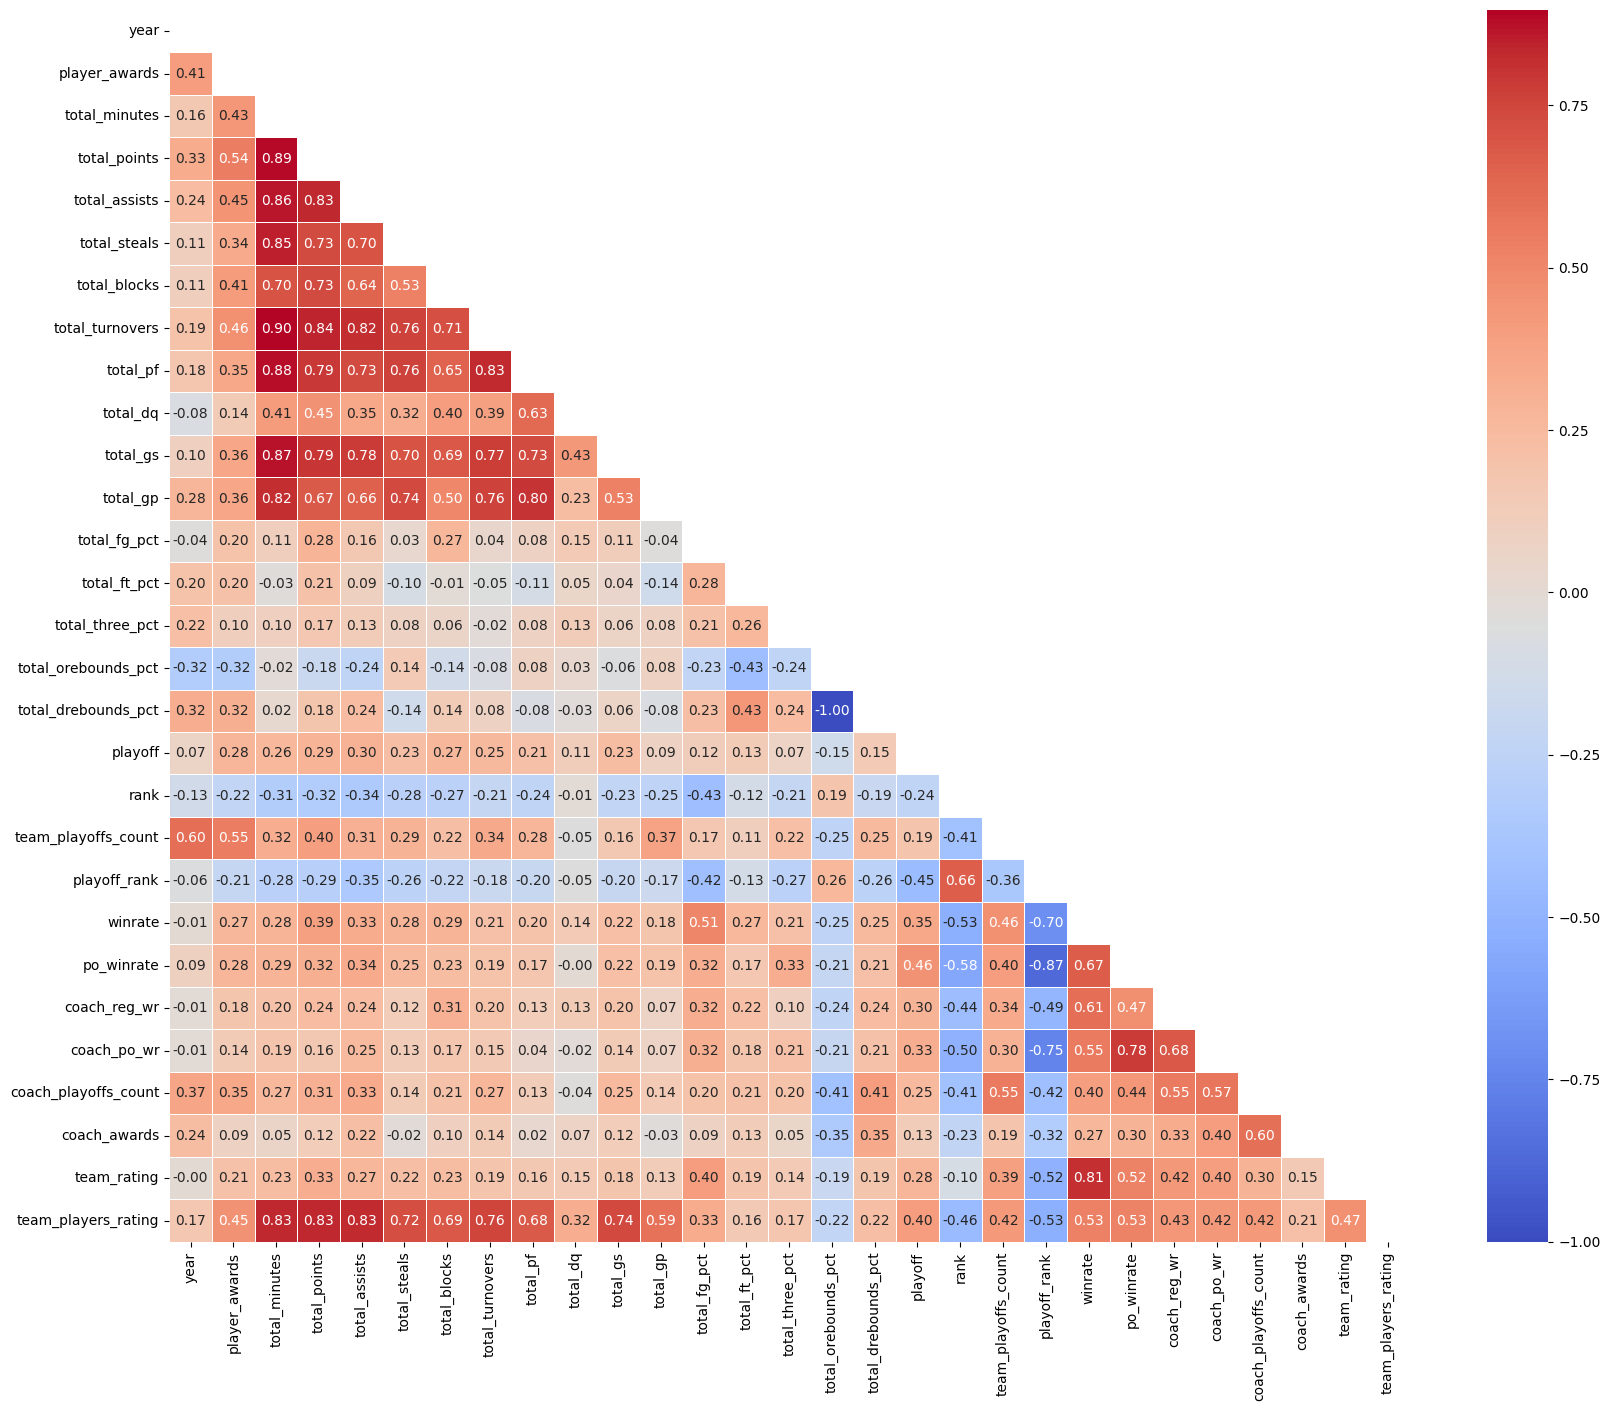


Pairs with high correlation (> 0.75):
total_minutes and total_points: 0.89
total_minutes and total_steals: 0.85
total_minutes and total_turnovers: 0.90
total_minutes and total_pf: 0.88
total_points and total_turnovers: 0.84
total_assists and total_minutes: 0.86
total_assists and total_points: 0.83
total_assists and total_turnovers: 0.82
total_assists and total_gs: 0.78
total_steals and total_turnovers: 0.76
total_pf and total_points: 0.79
total_pf and total_steals: 0.76
total_pf and total_turnovers: 0.83
total_gs and total_minutes: 0.87
total_gs and total_points: 0.79
total_gs and total_turnovers: 0.77
total_gp and total_minutes: 0.82
total_gp and total_turnovers: 0.76
total_gp and total_pf: 0.80
total_drebounds_pct and total_orebounds_pct: -1.00
playoff_rank and po_winrate: -0.87
coach_po_wr and playoff_rank: -0.75
coach_po_wr and po_winrate: 0.78
team_rating and winrate: 0.81
team_players_rating and total_minutes: 0.83
team_players_rating and total_points: 0.83
team_players_rating a

In [23]:
data1_10 = merged_data[merged_data['year'] != 11]
fs.correlation_matrix(data1_10, 0.75)

Initially, we planned to automatically delete one feature from pairs with good correlation (> 0.9). Upon deeper examination, this strategy turned out to be less "viable". A pair should be chosen for retention or discarding based on predetermined standards, taking into account the particular context of the dataset. Even when two qualities are highly correlated, their individual and combined effects on other aspects might differ. It becomes necessary to do a detailed analysis to make sure that our choices for data preparation take into account the complexities of the dataset in question and to prevent us from missing important information.


#### **Point Bisserial Correlation**
In order to evaluate the relationship between the **continuous** variables and the **binary** target (playoff), we will apply a statistical measure designed to account for these kinds of situations. This approach considers the connection between a continuous and a binary variable, offering important new information about that relationship. We can better understand how the continuous attributes affect the playoff result by doing this test to find patterns and linkages in the data. By using this analytical method, we want to better understand the underlying dynamics and determinants that determine whether a team makes the playoffs or not given its attributes.

In [24]:
fs.bisserial_corr(data1_10)

po_winrate: 45.62% correlation
playoff_rank: 45.04% correlation
team_players_rating: 40.15% correlation
winrate: 34.91% correlation
coach_po_wr: 32.54% correlation
total_assists: 29.99% correlation
coach_reg_wr: 29.64% correlation
total_points: 28.92% correlation
team_rating: 27.80% correlation
player_awards: 27.79% correlation
total_blocks: 26.97% correlation
total_minutes: 26.44% correlation
total_turnovers: 25.48% correlation
coach_playoffs_count: 24.50% correlation
rank: 24.16% correlation
total_gs: 23.08% correlation
total_steals: 22.88% correlation
total_pf: 21.06% correlation
team_playoffs_count: 19.10% correlation
total_drebounds_pct: 14.76% correlation
total_orebounds_pct: 14.76% correlation
total_ft_pct: 13.38% correlation
coach_awards: 12.93% correlation
total_fg_pct: 11.87% correlation
total_dq: 11.23% correlation
total_gp: 8.83% correlation
total_three_pct: 7.22% correlation


The majority of attributes demonstrate a statistically significant correlation, save for **total_ft_pct** and **total_three_pct**. This anomaly may be attributed to their representation as percentages, since the correlation test predominantly accounts for linear relationships hence their values. Despite registering low correlation coefficients, these features remain pertinent, as their relevance is nuanced and contextually contingent, underscoring the importance of considering non-linear dynamics in data interpretation.

#### **Dividing the dataset in both train & test sets**



We'll transform the remaining non-numerical attributes into integers, a step favored by models for optimal performance with numerical inputs. Employing a label encoder, each distinct teamID & confID will be assigned a unique integer. Following this encoding, we'll partition the dataset into training and testing sets, laying the groundwork for effective model evaluation and prediction.

The train & test data is divided in the following format:
- The training data will be all years prior to the year we want to predict
- The test data will be the year we want to predict

In [25]:
label_encoder = LabelEncoder()

merged_data['tmid'] = label_encoder.fit_transform(merged_data['tmid'])
merged_data['confid'] = label_encoder.fit_transform(merged_data['confid'])

x = merged_data.drop('playoff', axis=1)
y = merged_data['playoff']

x_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)].drop('playoff', axis=1)
y_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)]['playoff']

x_test = merged_data[merged_data['year'] == TEST_YEAR].drop('playoff', axis=1)
y_test = merged_data[merged_data['year'] == TEST_YEAR]['playoff']

### RFE
We will be running Recursive Feature Elimination (RFE) across various models, including **Random Forest**, **Logistic Regression**, **Support Vector Machine**, and **Gradient Boosting**, to discern the optimal set of features for each. This involves systematically evaluating the performance of different feature subsets by testing varying numbers of features. Through the **RFE** process, we aim to identify not only the ideal number of features but also the specific attributes that contribute most significantly to the models' efficacy. By iteratively refining the feature selection, we seek to enhance the models' predictive power and streamline their performance with the most influential and relevant variables.

In [26]:
print("Final Features:")
print(x_train.columns)
min_features = 20

"""rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Support Vector Machine': SVC(random_state=42, kernel='linear'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}"""
rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}


classifiers_features = {}

total_features = len(x_train.columns)

best_model_info = {}


for model_name, model in rfe_classifiers.items():
    print(f"\033[1mModel: {model_name}\033[0m")
    
    results = []

    for i in range(min_features, total_features):
        rfe = RFE(model, n_features_to_select=i)
        rfe.fit(x_train, y_train)
        
        selected_features = set(x_train.columns[rfe.support_])
        selected_features.add("tmid")
        selected_features.add("year")
        selected_features = list(selected_features)

        model.fit(x_train[selected_features], y_train)

        accuracy = model.score(x_test[selected_features], y_test)

        results.append((selected_features, accuracy))
    

    # Sort the results based on accuracy in descending order
    results = sorted(results, key=lambda x: x[1], reverse=True)

    classifiers_features[model_name] = results[0][0]
    best_model_info[model_name] = {'features': results[0][0], 'accuracy': results[0][1], 'model': model}
    
    # Print the results
    for features, accuracy in results[:3]:
        print("Selected Features:", features)
        print("Accuracy:" + str(accuracy) + '\n')

best_model_name = max(best_model_info, key=lambda k: best_model_info[k]['accuracy'])
best_model = best_model_info[best_model_name]['model']
best_features = best_model_info[best_model_name]['features']

print(f"\033[1mBest Model: {best_model_name}\033[0m")
print(f"Best Features: {best_features}")
print(f"Accuracy: {best_model_info[best_model_name]['accuracy']}\n")

Final Features:
Index(['year', 'tmid', 'player_awards', 'total_minutes', 'total_points',
       'total_assists', 'total_steals', 'total_blocks', 'total_turnovers',
       'total_pf', 'total_dq', 'total_gs', 'total_gp', 'total_fg_pct',
       'total_ft_pct', 'total_three_pct', 'total_orebounds_pct',
       'total_drebounds_pct', 'confid', 'rank', 'team_playoffs_count',
       'playoff_rank', 'winrate', 'po_winrate', 'coach_reg_wr', 'coach_po_wr',
       'coach_playoffs_count', 'coach_awards', 'team_rating',
       'team_players_rating'],
      dtype='object')
Model: Random Forest
Selected Features: ['total_assists', 'total_fg_pct', 'total_three_pct', 'coach_playoffs_count', 'total_pf', 'total_points', 'total_ft_pct', 'coach_po_wr', 'tmid', 'total_minutes', 'year', 'player_awards', 'total_blocks', 'playoff_rank', 'total_steals', 'total_turnovers', 'coach_reg_wr', 'team_rating', 'total_dq', 'team_playoffs_count', 'total_orebounds_pct', 'total_gs', 'winrate', 'po_winrate', 'total_gp', 'ran

While applying a similar approach, we encountered a deviation when working with **K-Nearest Neighbors (KNN)**. Recursive Feature Elimination (RFE) wasn't conducive to the intricacies of KNN. To address this, we seamlessly pivoted to an alternative strategy, implementing **SelectKBest** for feature selection tailored to KNN's dynamics. 

In [27]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
results = []
knn = KNeighborsClassifier()
for i in range(min_features, total_features):
   

    selector = SelectKBest(score_func=mutual_info_classif, k=i)
    selector.fit(x_train, y_train)


    selected_features = set(x_train.columns[selector.get_support()])
    selected_features.add("tmid")
    selected_features.add("year")
    selected_features = list(selected_features)

    knn.fit(x_train[selected_features], y_train)

    accuracy = knn.score(x_test[selected_features], y_test)

    results.append((selected_features, accuracy))

results = sorted(results, key=lambda x: x[1], reverse=True)

classifiers_features["K-Nearest Neighbors"] = results[0][0]

# Print the best 3 results
for features, accuracy in results[:3]:
    print("Selected Features:", features)
    print("Accuracy:" + str(accuracy) + '\n')



Selected Features: ['total_assists', 'total_fg_pct', 'total_three_pct', 'coach_playoffs_count', 'confid', 'total_points', 'total_ft_pct', 'coach_po_wr', 'tmid', 'year', 'player_awards', 'playoff_rank', 'coach_awards', 'total_steals', 'coach_reg_wr', 'team_rating', 'total_dq', 'team_playoffs_count', 'total_orebounds_pct', 'total_gs', 'po_winrate', 'winrate', 'total_gp', 'rank', 'total_drebounds_pct', 'team_players_rating']
Accuracy:0.8461538461538461

Selected Features: ['total_assists', 'total_fg_pct', 'total_three_pct', 'coach_playoffs_count', 'total_pf', 'confid', 'total_points', 'total_ft_pct', 'coach_po_wr', 'tmid', 'total_minutes', 'year', 'player_awards', 'total_blocks', 'playoff_rank', 'coach_awards', 'total_steals', 'total_turnovers', 'coach_reg_wr', 'team_rating', 'total_dq', 'team_playoffs_count', 'total_orebounds_pct', 'total_gs', 'winrate', 'po_winrate', 'total_gp', 'rank', 'total_drebounds_pct', 'team_players_rating']
Accuracy:0.8461538461538461

Selected Features: ['total

#### **Models Performance**

Choosing the model with the most promising results in the **tenth** year prompted us to scrutinize its performance across the entire temporal spectrum. We conducted a comprehensive assessment by testing the model on all available years and calculating the average accuracy. Recognizing that excelling in a single year may not be indicative of overall effectiveness, this method ensures a robust evaluation, considering the model's consistency and adaptability across diverse temporal contexts.

In [28]:
accuracy_scores = []

best_model = best_model_info[best_model_name]['model']
best_features = best_model_info[best_model_name]['features']
print(best_model)
probs = False
for test_year in range(3, 11):  # Testing from year 2 to 10
    x_train = merged_data[merged_data['year'].between(1, test_year - 1)].drop('playoff', axis=1)
    y_train = merged_data[merged_data['year'].between(1, test_year - 1)]['playoff']
    
    x_test = merged_data[merged_data['year'] == test_year].drop('playoff', axis=1)
    y_test = merged_data[merged_data['year'] == test_year]['playoff']
    
    # Training the model
    best_model.fit(x_train[best_features], y_train)
    if(probs):
        # Testing the model
        probabilities = best_model.predict_proba(x_test[best_features])
        x_test['probabilities'] = probabilities.tolist()

        
        top_4_teams = (
            x_test.groupby('confid')
            .apply(lambda x: x.iloc[np.argsort(-np.array(x['probabilities'].tolist())[:, 0])][:4])
            .reset_index(drop=True)['tmid']
            .tolist()
        )

        # Create a list where 1 represents the team with one of the top 4 probabilities in their conference
        final_list = [0 if tmid in top_4_teams else 1 for tmid in x_test['tmid']]


        # Calculating accuracy
        accuracy = accuracy_score(y_test, final_list)
        accuracy_scores.append(accuracy)
    else:
        predictions = best_model.predict(x_test[best_features])
    
        # Calculating accuracy
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
    print(predictions)
    print(f"Accuracy for testing year {test_year}: {accuracy}")
    
# Calculating average accuracy
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print(f"\nAverage Accuracy across all years: {average_accuracy}\n\n")


for model_name, model in rfe_classifiers.items():
    print(model_name)
    for test_year in range(3, 11): 
        x_train = merged_data[merged_data['year'].between(1, test_year - 1)].drop('playoff', axis=1)
        y_train = merged_data[merged_data['year'].between(1, test_year - 1)]['playoff']
        
        x_test = merged_data[merged_data['year'] == test_year].drop('playoff', axis=1)
        y_test = merged_data[merged_data['year'] == test_year]['playoff']
        
        # Training the model
        model.fit(x_train[classifiers_features[model_name]], y_train)
        
        predictions = model.predict(x_test[classifiers_features[model_name]])
        
        # Calculating accuracy
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
        print(f"Accuracy for testing year {test_year}: {accuracy}")

    # Calculating average accuracy
    average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    
    print(f"\nAverage Accuracy across all years: {average_accuracy}")
    print("\n\n")


LogisticRegression(max_iter=10000, random_state=42)
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
Accuracy for testing year 3: 0.5
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
Accuracy for testing year 4: 0.42857142857142855
[0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
Accuracy for testing year 5: 0.5384615384615384
[0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]
Accuracy for testing year 6: 0.8461538461538461
[0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
Accuracy for testing year 7: 0.8571428571428571
[0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
Accuracy for testing year 8: 0.6923076923076923
[0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
Accuracy for testing year 9: 0.7857142857142857
[1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
Accuracy for testing year 10: 0.8461538461538461

Average Accuracy across all years: 0.6868131868131868


Random Forest
Accuracy for testing year 3: 0.5625
Accuracy for testing year 4: 0.42857142857142855
Accuracy for testing year 5: 0.5384615384615384
Accuracy for testing year 6

In [29]:

x_train = merged_data[merged_data['year'].between(1, 10)].drop('playoff', axis=1)
y_train = merged_data[merged_data['year'].between(1, 10)]['playoff']

x_test = merged_data[merged_data['year'] == 11].drop('playoff', axis=1)
y_test = merged_data[merged_data['year'] == 11]['playoff']

print(classifiers_features)
print(best_model)

best_model.fit(x_train[best_features], y_train)
predictions = best_model.predict(x_test[best_features])
print(predictions)


y_t = [1,0,0,1,1,0,1,1,1,1,0,1]

print("11 year Accuray:",accuracy_score(y_t, predictions))


{'Random Forest': ['total_assists', 'total_fg_pct', 'total_three_pct', 'coach_playoffs_count', 'total_pf', 'total_points', 'total_ft_pct', 'coach_po_wr', 'tmid', 'total_minutes', 'year', 'player_awards', 'total_blocks', 'playoff_rank', 'total_steals', 'total_turnovers', 'coach_reg_wr', 'team_rating', 'total_dq', 'team_playoffs_count', 'total_orebounds_pct', 'total_gs', 'winrate', 'po_winrate', 'total_gp', 'rank', 'total_drebounds_pct', 'team_players_rating'], 'Logistic Regression': ['total_fg_pct', 'total_three_pct', 'coach_playoffs_count', 'total_pf', 'confid', 'total_ft_pct', 'coach_po_wr', 'tmid', 'total_minutes', 'year', 'player_awards', 'total_blocks', 'playoff_rank', 'coach_awards', 'total_steals', 'total_turnovers', 'coach_reg_wr', 'team_rating', 'total_dq', 'team_playoffs_count', 'total_orebounds_pct', 'total_gs', 'winrate', 'po_winrate', 'total_gp', 'rank', 'total_drebounds_pct', 'team_players_rating'], 'Gradient Boosting': ['total_assists', 'total_fg_pct', 'total_three_pct', 

#### GridSearch
Now that we know the best features for each model, we will use gridsearch to fine tune its parameters.

In [30]:
#best_params = fs.grid_search(classifiers_features,x_train,x_test,y_train,y_test)
#print(best_params)

# Random Forest -> {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

# Logistic -> {'C': 100, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}

# SVM -> {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

# Gradient -> {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}

# KNN ->  {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
"""
import time

model_params = {'Random Forest': {'random_state':42, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}, 'Logistic Regression': {'random_state':42, 'C': 100, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 10000}, 'Support Vector Machine': {'random_state':42, 'C': 10, 'gamma': 'scale', 'kernel': 'linear'}, 'Gradient Boosting': {'random_state':42,'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}, 'K-Nearest Neighbors': {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}}

final_classifiers = {
    'Random Forest': RandomForestClassifier(random_state =42),
    'Logistic Regression': LogisticRegression(random_state =42),
    'Support Vector Machine': SVC(random_state =42),
    'Gradient Boosting': GradientBoostingClassifier(random_state =42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
}

for model_name, model in final_classifiers.items():
    start = time.time()
    model.fit(x_train[classifiers_features[model_name]], y_train)
    y_pred = model.predict(x_test[classifiers_features[model_name]])
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    end = time.time()
    print(f'Accuracy for {model_name}: {accuracy}')
    print(f'AUC for {model_name}: {auc}')
    print(end-start)
"""

"\nimport time\n\nmodel_params = {'Random Forest': {'random_state':42, 'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}, 'Logistic Regression': {'random_state':42, 'C': 100, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 10000}, 'Support Vector Machine': {'random_state':42, 'C': 10, 'gamma': 'scale', 'kernel': 'linear'}, 'Gradient Boosting': {'random_state':42,'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}, 'K-Nearest Neighbors': {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}}\n\nfinal_classifiers = {\n    'Random Forest': RandomForestClassifier(random_state =42),\n    'Logistic Regression': LogisticRegression(random_state =42),\n    'Support Vector Machine': SVC(random_state =42),\n    'Gradient Boosting': GradientBoostingClassifier(random_state =42),\n    'K-Nearest Neighbors': KNeighborsClassifier(),\n}\n\nfor model_name, model in fina